In [242]:
# export PATH=$PATH:$HOME/.local/bin
# bcftools mpileup -f ~/hg38/bwa/hg38/hg38.fa -q 20 -r chr2 -g 10 -O v --threads 4 P10.dedups.bam P142.dedups.bam P143.dedups.bam P181.dedups.bam | bcftools filter --include "INFO/DP>=10" -o enrich.DP10.vcf
## or 
## ls *.bam | while read -r line; do echo $(realpath $line); done > bamlist.txt
## bcftools mpileup -f ~/hg38/bwa/hg38/hg38.fa -q 20 -r chr2 -g 10 -O v --threads 4 --bam-list bamlist.txt | bcftools filter --include "INFO/DP>=10" -o allBams.DP10.vcf
# for i in *.bam; do \
# echo $i; \
# bcftools mpileup -f ~/hg38/bwa/hg38/hg38.fa -q 20 -r chr2 -a DP -O v --threads 8 $(realpath $i) | bcftools filter --include "INFO/DP>=10" -o $i.individual.DP10.vcf; \
# done;

# bcftools call -m enrich.DP10.vcf > enrich.DP10.calls.vcf

# for i in *.individual.*.vcf; do echo $i; bcftools view -Oz -o  $i.compressed.gz $i; done
# for i in *.individual.*call*.vcf; do echo $i; bcftools index $i.compressed.gz $i; done
# ls *call*.vcf.*.gz > vcf-list.txt

## remaining bams from Galina:
# for i in {1,2,3,6}; do \
# for j in {1,2}; do \
#     echo ${i}-${j}; \
#     bcftools mpileup -f ~/hg38/bwa/hg38/hg38.fa -q 20 -r chr2 -a DP -O v --threads 8 \
#         "/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/${i}-${j}Aligned.out.sorted.bam" \
#         | bcftools filter --include "INFO/DP>=10" -o "${i}-${j}Aligned.out.sorted.bam.individual.DP10.vcf"; \
#         bcftools view -Oz -o ${i}-${j}Aligned.out.sorted.bam.individual.DP10.vcf.compressed.gz \
#                              ${i}-${j}Aligned.out.sorted.bam.individual.DP10.vcf; \
#         bcftools index ${i}-${j}Aligned.out.sorted.bam.individual.DP10.vcf.compressed.gz; \
# done; \
# done;

# for i in {1,2,3,4,5,6}; do \
# for j in {1,2}; do \
#     echo ${i}-${j}; \
#       callfile="${i}-${j}Aligned.out.sorted.bam.individual.DP10.call.vcf"; \
#       if [[ -f $callfile ]] || [[ -f "RNA_seq_$callfile" ]]; \
#       then \
#           echo "$callfile yes"; \ 
#       else \
#            echo "$callfile no"; \
#     bcftools mpileup -f ~/hg38/bwa/hg38/hg38.fa -q 20 -r chr2 -a DP -O v --threads 8 \
#         "/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/${i}-${j}Aligned.out.sorted.bam" \
#         | bcftools filter --include "INFO/DP>=10" -o "${i}-${j}Aligned.out.sorted.bam.individual.DP10.vcf"; \
#         bcftools call -m ${i}-${j}Aligned.out.sorted.bam.individual.DP10.vcf > ${i}-${j}Aligned.out.sorted.bam.i
# for i in {1,2,3,6}; do \
# for j in {1,2}; do \
#     echo ${i}-${j}; \
#     bcftools call -m ${i}-${j}Aligned.out.sorted.bam.individual.DP10.vcf > \
#                       ${i}-${j}Aligned.out.sorted.bam.individual.DP10.call.vcf; \
#         bcftools view -Oz -o ${i}-${j}Aligned.out.sorted.bam.individual.DP10.call.vcf.compressed.gz \
#                              ${i}-${j}Aligned.out.sorted.bam.individual.DP10.call.vcf; \
#         bcftools index ${i}-${j}Aligned.out.sorted.bam.individual.DP10.call.vcf.compressed.gz; \
# done; \
# done;
ndividual.DP10.call.vcf; \
#         bcftools view -Oz -o ${i}-${j}Aligned.out.sorted.bam.individual.DP10.call.vcf.compressed.gz \
#                              ${i}-${j}Aligned.out.sorted.bam.individual.DP10.call.vcf; \
#         bcftools index ${i}-${j}Aligned.out.sorted.bam.individual.DP10.call.vcf.compressed.gz; \
#       fi; \
# done; \
# done;      


# bcftools merge  --file-list vcf-list.txt -o allBams.DP10.merged.vcf
# bcftools merge  --file-list vcf-list-filtered.txt -o allBams.DP10.filtered.merged.vcf


IndentationError: unexpected indent (3962098591.py, line 33)

In [204]:
import vcfpy
import numpy as np
import pandas as pd
import tqdm

In [ ]:
def compare2samples(c1,c2,s1,s2, chrom, pos, minDP=20):
    assert c1.sample == s1
    assert c2.sample == s2
    # given the list of genotypes
    # compute consistency of same_sample and parent_offspring
    for c in c1,c2:
        if c.data["DP"] is None or c.data["DP"] < minDP:
            return {"status":"low_DP_" + c.sample}

    for c in c1,c2:
        if c.data["GT"] == "./.":
            return {"status":"unknown_GT" + c.sample}
    
    if c1.data["GT"] == c2.data["GT"] == "0/0":
            return {"status":"both_ref"}        
        
    result = {}
    result["status"] = "done"
    result["data"] = []
    
    g1 = np.array(list(map(int,c1.data["GT"].split("/"))))
    assert len(g1) == 2

    g2 = np.array(list(map(int,c2.data["GT"].split("/"))))
    assert len(g2) == 2
    bc1 = np.bincount(g1, minlength=max(max(g1),max(g2))+1)
    bc2 = np.bincount(g2, minlength=max(max(g1),max(g2))+1)
    overlap = np.minimum(bc1,bc2).sum()
    assert overlap>=0
    assert overlap<=2

    result["data"].append([chrom,pos,c1.sample,c2.sample,overlap])
    result["data"].append([chrom,pos,c2.sample,c1.sample,overlap])
    # if c1.data["GT"] != "0/0":
    #     print (c1.data["GT"],c2.data["GT"],overlap)
    
    return result

num = 0
minDP = 15
results = []
status_counts = {}

filename = "allBams.DP10.filtered.merged.vcf"
# filename = "allBams.DP10.calls.vcf"
# filename = "enrich.DP10.calls.vcf"

reader = vcfpy.Reader.from_path(filename)
snames = reader.header.samples.names

for record in tqdm.tqdm(reader):
    # alt_types = list(set([a.type for a in record.ALT]))
    # # only keep ref calls (SYMBOLIC) and SNVs
    # if len(alt_types) == 0:
    #     print (record)
    #     raise ValueError("No type info for record")
    # elif len(alt_types) == 1 and alt_types[0] != "SNV": 
    #     continue
    # elif len(alt_types) == 2 and not ("SNV" in alt_types and "SYMBOLIC" in alt_types):
    #     continue

    assert len(record.calls) == len(snames)
    for i,s1 in enumerate(snames):
        for j,s2 in enumerate(snames[i+1:]):
            j = j + i + 1
            r = compare2samples(record.calls[i],record.calls[j],s1,s2,record.CHROM, record.POS,
                               minDP = minDP)
            if r["status"] == "done":
                results.extend(r["data"])
            else:
                if r["status"] in status_counts.keys():
                    status_counts[r["status"]] += 1
                else:
                    status_counts[r["status"]] = 1
    num += 1
    # if num > 10000:
    #     break

4238304it [39:44, 1900.32it/s]

In [245]:
status_counts

{'low_DP_/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/1-1Aligned.out.sorted.bam': 167044542,
 'low_DP_/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/1-2Aligned.out.sorted.bam': 159116765,
 'low_DP_/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/2-1Aligned.out.sorted.bam': 148314051,
 'low_DP_/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/2-2Aligned.out.sorted.bam': 139649605,
 'low_DP_/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/3-1Aligned.out.sorted.bam': 131563844,
 'low_DP_/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/3-2Aligned.out.sorted.bam': 123753642,
 'low_DP_/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/4-2Aligned.out.sorted.bam': 115174765,
 'low_DP_/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/6-1Aligned.out.sorted.bam': 106002935,
 'low_DP_/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/6-2Aligned.out.sorted.bam': 97347237,
 'low_DP_/sf/storage/gmo/hic/out/by_Project/Six2/BAC_enrichment/July24_bam/trimmed/

In [246]:
snames

['/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/1-1Aligned.out.sorted.bam',
 '/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/1-2Aligned.out.sorted.bam',
 '/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/2-1Aligned.out.sorted.bam',
 '/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/2-2Aligned.out.sorted.bam',
 '/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/3-1Aligned.out.sorted.bam',
 '/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/3-2Aligned.out.sorted.bam',
 '/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/4-2Aligned.out.sorted.bam',
 '/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/6-1Aligned.out.sorted.bam',
 '/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/6-2Aligned.out.sorted.bam',
 '/sf/storage/gmo/hic/out/by_Project/Six2/BAC_enrichment/July24_bam/trimmed/P10.dedups.bam',
 '/sf/storage/gmo/hic/out/by_Project/Six2/BAC_enrichment/July24_bam/trimmed/P142.dedups.bam',
 '/sf/storage/gmo/hic/out/by_Project/Six2/BAC_enrichment/

In [247]:
results = pd.DataFrame.from_records(results, columns=["chrom","pos","s1","s2","shAllels"])
results

chrom        pos                                                 s1  \
0       chr2     218386  /sf/storage/gmo/hic/out/by_User/Galya/rnaseq_b...   
1       chr2     218386  /sf/storage/gmo/hic/out/by_User/Galya/rnaseq_b...   
2       chr2     218386  /sf/storage/gmo/hic/out/by_User/Galya/rnaseq_b...   
3       chr2     218386  /sf/storage/gmo/hic/out/by_User/Galya/rnaseq_b...   
4       chr2     218386  /sf/storage/gmo/hic/out/by_User/Galya/rnaseq_b...   
...      ...        ...                                                ...   
480599  chr2  241768657  /sf/storage/gmo/hic/out/by_User/Galya/rnaseq_b...   
480600  chr2  241768657  /sf/storage/gmo/hic/out/by_User/Galya/rnaseq_b...   
480601  chr2  241768657  /sf/storage/gmo/hic/out/by_User/Galya/rnaseq_b...   
480602  chr2  241768657  /sf/storage/gmo/hic/out/by_User/Galya/rnaseq_b...   
480603  chr2  241768657  /sf/storage/gmo/hic/out/by_User/Galya/rnaseq_b...   

                                                       s2  shAllels  
0       /sf/storage/gmo/hic/out/by_User/Galya/rnaseq_b...         2  
1       /sf/storage/gmo/hic/out/by_User/Galya/rnaseq_b...         2  
2       /sf/storage/gmo/hic/out/by_User/Galya/rnaseq_b...         2  
3       /sf/storage/gmo/hic/out/by_User/Galya/rnaseq_b...         2  
4       /sf/storage/gmo/hic/out/by_User/Galya/rnaseq_b...         2  
...                                                   ...       ...  
480599  /sf/storage/gmo/hic/out/by_User/Galya/rnaseq_b...         1  
480600  /sf/storage/gmo/hic/out/by_User/Galya/rnaseq_b...         1  
480601  /sf/storage/gmo/hic/out/by_User/Galya/rnaseq_b...         1  
480602  /sf/storage/gmo/hic/out/by_User/Galya/rnaseq_b...         1  
480603  /sf/storage/gmo/hic/out/by_User/Galya/rnaseq_b...         1  

[480604 rows x 5 columns]

In [248]:
results["s1"].unique()

array(['/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/142Aligned.out.sorted.bam',
       '/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/181-1Aligned.out.sorted.bam',
       '/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/181-2Aligned.out.sorted.bam',
       '/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/3-2Aligned.out.sorted.bam',
       'F008254-4-I-ExC93-xgenV2',
       '/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/6-1Aligned.out.sorted.bam',
       '/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/6-2Aligned.out.sorted.bam',
       '/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/1-1Aligned.out.sorted.bam',
       '/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/2-2Aligned.out.sorted.bam',
       '/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/5-1Aligned.out.sorted.bam',
       '/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six/2-1Aligned.out.sorted.bam',
       '/sf/storage/gmo/hic/out/by_User/Galya/rnaseq_bams/six

In [259]:
# for i in np.unique(np.concat([results["s1"].values,results["s2"].values])):
#     print (i.split("/")[-1])
renamer = {
    "P10.dedups.bam":"enrich_P10",
    "P142.dedups.bam":"enrich_P142",
    "P143.dedups.bam":"enrich_P143",
    "P181.dedups.bam":"enrich_P181",
    "142Aligned.out.sorted.bam":"RNAseq_P142",
    "181-1Aligned.out.sorted.bam":"RNAseq_181-1",
    "181-2Aligned.out.sorted.bam":"RNAseq_181-2",
    "4-1Aligned.out.sorted.bam":"RNAseq_4-1g-P142",
    "5-1Aligned.out.sorted.bam":"RNAseq_5-1g-P181",
    "5-2Aligned.out.sorted.bam":"RNAseq_5-2g-P181",
    "1-1.bam":"RNAseq_1-1",
    "1-2.bam":"RNAseq_1-2",
    "2-1.bam":"RNAseq_2-1",
    "2-2.bam":"RNAseq_2-2",
    "3-1.bam":"RNAseq_3-1-P143",
    "3-2.bam":"RNAseq_3-2-P143",
    "4-1.bam":"RNAseq_4-1-P142",
    "4-2.bam":"RNAseq_4-2-P142",
    "5-1.bam":"RNAseq_5-1-P181",
    "5-2.bam":"RNAseq_5-2-P181",
    "6-1.bam":"RNAseq_6-1",
    "6-2.bam":"RNAseq_6-2",
    "1-1Aligned.out.sorted.bam":"RNAseq_1-1",
    "1-2Aligned.out.sorted.bam":"RNAseq_1-2",
    "2-1Aligned.out.sorted.bam":"RNAseq_2-1",
    "2-2Aligned.out.sorted.bam":"RNAseq_2-2",
    "3-1Aligned.out.sorted.bam":"RNAseq_3-1-P143",
    "3-2Aligned.out.sorted.bam":"RNAseq_3-2-P143",
    "4-1Aligned.out.sorted.bam":"RNAseq_4-1-P142",
    "4-2Aligned.out.sorted.bam":"RNAseq_4-2-P142",
    "5-1Aligned.out.sorted.bam":"RNAseq_5-1-P181",
    "5-2Aligned.out.sorted.bam":"RNAseq_5-2-P181",
    "6-1Aligned.out.sorted.bam":"RNAseq_6-1",
    "6-2Aligned.out.sorted.bam":"RNAseq_6-2",
    "F008254-4-I-ExC93-xgenV2":"exome_P142",
}
renamer

{'P10.dedups.bam': 'enrich_P10',
 'P142.dedups.bam': 'enrich_P142',
 'P143.dedups.bam': 'enrich_P143',
 'P181.dedups.bam': 'enrich_P181',
 '142Aligned.out.sorted.bam': 'RNAseq_P142',
 '181-1Aligned.out.sorted.bam': 'RNAseq_181-1',
 '181-2Aligned.out.sorted.bam': 'RNAseq_181-2',
 '4-1Aligned.out.sorted.bam': 'RNAseq_4-1-P142',
 '5-1Aligned.out.sorted.bam': 'RNAseq_5-1-P181',
 '5-2Aligned.out.sorted.bam': 'RNAseq_5-2-P181',
 '1-1.bam': 'RNAseq_1-1',
 '1-2.bam': 'RNAseq_1-2',
 '2-1.bam': 'RNAseq_2-1',
 '2-2.bam': 'RNAseq_2-2',
 '3-1.bam': 'RNAseq_3-1-P143',
 '3-2.bam': 'RNAseq_3-2-P143',
 '4-1.bam': 'RNAseq_4-1-P142',
 '4-2.bam': 'RNAseq_4-2-P142',
 '5-1.bam': 'RNAseq_5-1-P181',
 '5-2.bam': 'RNAseq_5-2-P181',
 '6-1.bam': 'RNAseq_6-1',
 '6-2.bam': 'RNAseq_6-2',
 '1-1Aligned.out.sorted.bam': 'RNAseq_1-1',
 '1-2Aligned.out.sorted.bam': 'RNAseq_1-2',
 '2-1Aligned.out.sorted.bam': 'RNAseq_2-1',
 '2-2Aligned.out.sorted.bam': 'RNAseq_2-2',
 '3-1Aligned.out.sorted.bam': 'RNAseq_3-1-P143',
 '3-2Al

In [260]:
results["s1short"] = results["s1"].apply(lambda x: renamer[x.split("/")[-1]])
results["s2short"] = results["s2"].apply(lambda x: renamer[x.split("/")[-1]])

In [261]:
results.to_csv(filename+f".results_DP{minDP}.csv.gz")

In [262]:
_ = results.groupby(["s1short","s2short"])["shAllels"].apply(lambda x: pd.concat([x.value_counts(),
                                                                   x.value_counts(normalize=True)],
                                                                   axis=1
                                                                  ).sort_index())
_

count  proportion
s1short    s2short                          
RNAseq_1-1 RNAseq_1-2   0      3    0.001818
                        1    126    0.076364
                        2   1521    0.921818
           RNAseq_181-1 0      3    0.002020
                        1    105    0.070707
...                          ...         ...
exome_P142 enrich_P143  1      4    0.400000
                        2      2    0.200000
           enrich_P181  0      3    0.300000
                        1      6    0.600000
                        2      1    0.100000

[974 rows x 2 columns]

In [263]:
summary = _.reset_index().rename(columns={"level_2":"n_alleles"})
summary["experiment1"] = summary["s1short"].apply(lambda x: x.split("_")[0])
summary["experiment2"] = summary["s2short"].apply(lambda x: x.split("_")[0])
summary

s1short       s2short  n_alleles  count  proportion experiment1  \
0    RNAseq_1-1    RNAseq_1-2          0      3    0.001818      RNAseq   
1    RNAseq_1-1    RNAseq_1-2          1    126    0.076364      RNAseq   
2    RNAseq_1-1    RNAseq_1-2          2   1521    0.921818      RNAseq   
3    RNAseq_1-1  RNAseq_181-1          0      3    0.002020      RNAseq   
4    RNAseq_1-1  RNAseq_181-1          1    105    0.070707      RNAseq   
..          ...           ...        ...    ...         ...         ...   
969  exome_P142   enrich_P143          1      4    0.400000       exome   
970  exome_P142   enrich_P143          2      2    0.200000       exome   
971  exome_P142   enrich_P181          0      3    0.300000       exome   
972  exome_P142   enrich_P181          1      6    0.600000       exome   
973  exome_P142   enrich_P181          2      1    0.100000       exome   

    experiment2  
0        RNAseq  
1        RNAseq  
2        RNAseq  
3        RNAseq  
4        RNAseq  
..          ...  
969      enrich  
970      enrich  
971      enrich  
972      enrich  
973      enrich  

[974 rows x 7 columns]

In [264]:
summary.query("s1short=='RNAseq_1-1'").head(20)

s1short          s2short  n_alleles  count  proportion experiment1  \
0   RNAseq_1-1       RNAseq_1-2          0      3    0.001818      RNAseq   
1   RNAseq_1-1       RNAseq_1-2          1    126    0.076364      RNAseq   
2   RNAseq_1-1       RNAseq_1-2          2   1521    0.921818      RNAseq   
3   RNAseq_1-1     RNAseq_181-1          0      3    0.002020      RNAseq   
4   RNAseq_1-1     RNAseq_181-1          1    105    0.070707      RNAseq   
5   RNAseq_1-1     RNAseq_181-1          2   1377    0.927273      RNAseq   
6   RNAseq_1-1     RNAseq_181-2          0      7    0.004818      RNAseq   
7   RNAseq_1-1     RNAseq_181-2          1    119    0.081900      RNAseq   
8   RNAseq_1-1     RNAseq_181-2          2   1327    0.913283      RNAseq   
9   RNAseq_1-1       RNAseq_2-1          0    172    0.078575      RNAseq   
10  RNAseq_1-1       RNAseq_2-1          1   1394    0.636820      RNAseq   
11  RNAseq_1-1       RNAseq_2-1          2    623    0.284605      RNAseq   
12  RNAseq_1-1       RNAseq_2-2          0    175    0.080349      RNAseq   
13  RNAseq_1-1       RNAseq_2-2          1   1388    0.637282      RNAseq   
14  RNAseq_1-1       RNAseq_2-2          2    615    0.282369      RNAseq   
15  RNAseq_1-1  RNAseq_3-1-P143          0    182    0.078045      RNAseq   
16  RNAseq_1-1  RNAseq_3-1-P143          1   1515    0.649657      RNAseq   
17  RNAseq_1-1  RNAseq_3-1-P143          2    635    0.272298      RNAseq   
18  RNAseq_1-1  RNAseq_3-2-P143          0    188    0.080860      RNAseq   
19  RNAseq_1-1  RNAseq_3-2-P143          1   1512    0.650323      RNAseq   

   experiment2  
0       RNAseq  
1       RNAseq  
2       RNAseq  
3       RNAseq  
4       RNAseq  
5       RNAseq  
6       RNAseq  
7       RNAseq  
8       RNAseq  
9       RNAseq  
10      RNAseq  
11      RNAseq  
12      RNAseq  
13      RNAseq  
14      RNAseq  
15      RNAseq  
16      RNAseq  
17      RNAseq  
18      RNAseq  
19      RNAseq

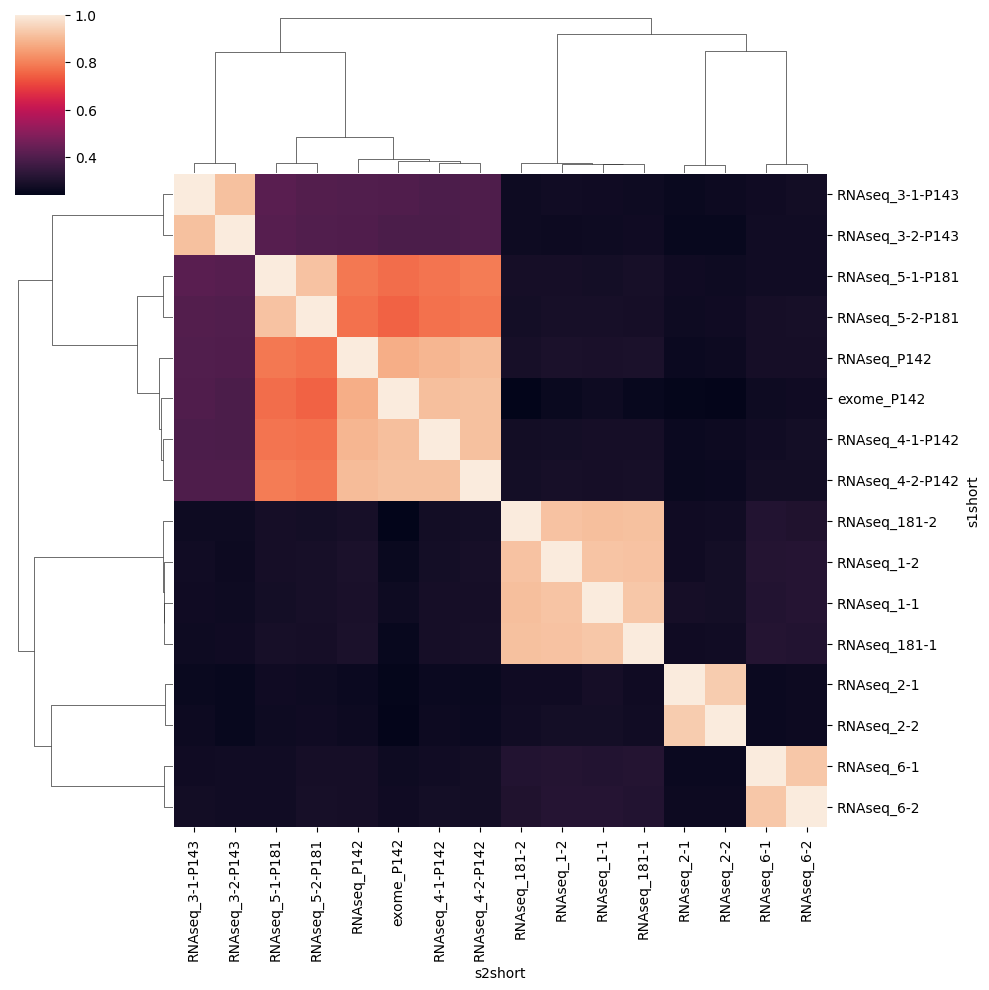

In [272]:
plot_data = summary.query("n_alleles==2 and (experiment1=='RNAseq' or experiment1=='exome') and (experiment2=='RNAseq' or experiment2=='exome')")[["s1short","s2short","proportion"]]\
                    .pivot(index="s1short", columns="s2short", values="proportion")
plot_data.fillna(1, inplace=True)
import seaborn as sns
# sns.clustermap(plot_data, method="average")
sns.clustermap(plot_data, method="average")

In [ ]:
plot_data = summary.query("n_alleles==2")[["s1short","s2short","proportion"]]\
                    .pivot(index="s1short", columns="s2short", values="proportion")
plot_data.fillna(0, inplace=True)
import seaborn as sns
sns.clustermap(plot_data, method="single")

In [21]:
results.query("s1=='P10.dedups.bam' and s2=='P142.dedups.bam' and shAllels==2")

chrom        pos              s1               s2  shAllels
0     chr2   18817433  P10.dedups.bam  P142.dedups.bam         2
54    chr2   44878392  P10.dedups.bam  P142.dedups.bam         2
130   chr2   44881924  P10.dedups.bam  P142.dedups.bam         2
170   chr2   44883915  P10.dedups.bam  P142.dedups.bam         2
226   chr2   44886713  P10.dedups.bam  P142.dedups.bam         2
...    ...        ...             ...              ...       ...
6892  chr2  113755545  P10.dedups.bam  P142.dedups.bam         2
6904  chr2  140618856  P10.dedups.bam  P142.dedups.bam         2
6916  chr2  140618860  P10.dedups.bam  P142.dedups.bam         2
6928  chr2  146673322  P10.dedups.bam  P142.dedups.bam         2
6954  chr2  235619401  P10.dedups.bam  P142.dedups.bam         2

[88 rows x 5 columns]

In [81]:
zygosity_per_sample = []
num = 0
reader = vcfpy.Reader.from_path('enrich.DP10.calls.vcf')
snames = reader.header.samples.names


for record in tqdm.tqdm(reader):
    assert len(record.calls) == len(snames)
    for c in record.calls:
        if c.data["GT"] == "0/0" or  c.data["GT"] == "./.":
            continue
        AD = sorted(c.data["AD"])
        if sum(AD)<10:
            continue
        assert len(AD) >= 2
        mAF = AD[-2]/(AD[-1]+AD[-2])
        homz =  c.data["GT"][0] == c.data["GT"][-1]
        zygosity_per_sample.append([c.sample, record.CHROM, record.POS, mAF, homz])

314161it [00:24, 12751.32it/s]


In [82]:
zygosity = pd.DataFrame.from_records(zygosity_per_sample, columns=["sample","chrom","pos","mAF", "homZ"])

In [83]:
zygosity

sample chrom        pos       mAF   homZ
0      P10.dedups.bam  chr2    4026973  0.000000   True
1     P142.dedups.bam  chr2    4026973  0.000000   True
2     P143.dedups.bam  chr2    4026973  0.000000   True
3     P181.dedups.bam  chr2    4026973  0.000000   True
4     P143.dedups.bam  chr2    5001228  0.400000  False
...               ...   ...        ...       ...    ...
1974   P10.dedups.bam  chr2  235619401  0.043478   True
1975  P142.dedups.bam  chr2  235619401  0.047619   True
1976  P143.dedups.bam  chr2  235619401  0.000000   True
1977  P181.dedups.bam  chr2  235619401  0.000000   True
1978   P10.dedups.bam  chr2  237609469  0.200000  False

[1979 rows x 5 columns]

(44889094.0, 45135813.0)

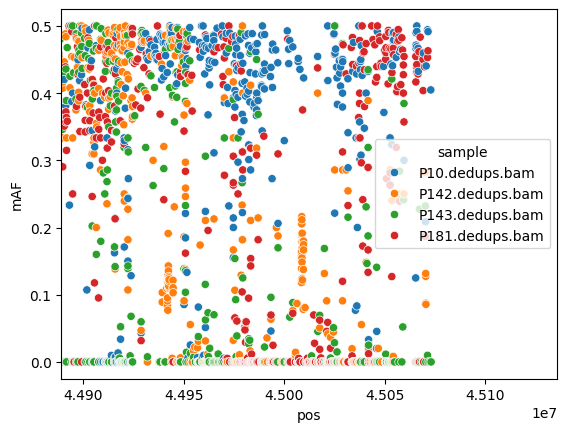

In [84]:
import matplotlib.pyplot as plt
sns.scatterplot(data=zygosity, x="pos", y="mAF",hue="sample")
plt.xlim(44889094,45135813)

(44889094.0, 45135813.0)

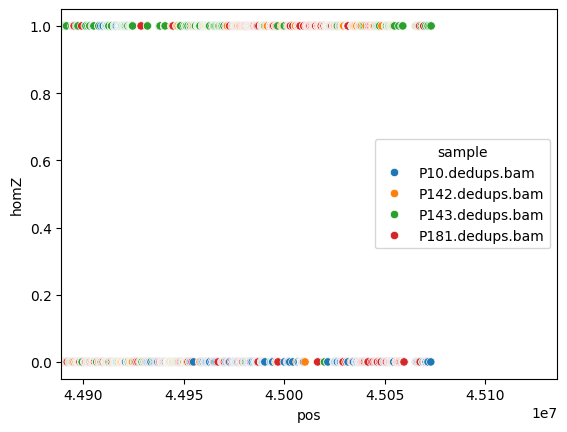

In [85]:
import matplotlib.pyplot as plt
sns.scatterplot(data=zygosity, x="pos", y="homZ",hue="sample")
plt.xlim(44889094,45135813)

In [125]:
binsize = 5000
roi_start = 44800000
roi_end = 45100000
zygosity["bin"] = zygosity["pos"] // binsize
zygosity["hetZ"] = zygosity["homZ"] - 1

gb = zygosity.groupby(["bin","sample"])[["homZ", "hetZ"]].agg("sum").reset_index()

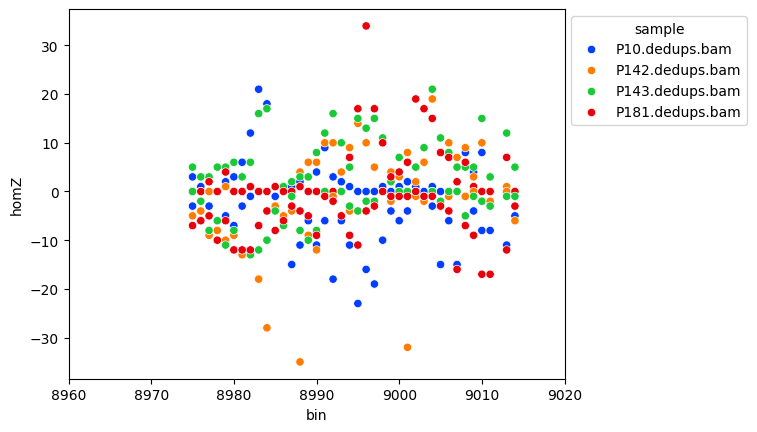

In [126]:
sns.scatterplot(data=gb, x="bin", y="homZ",hue="sample", palette="bright")
sns.scatterplot(data=gb, x="bin", y="hetZ",hue="sample", palette="bright", legend=False)
plt.xlim(roi_start//binsize, roi_end//binsize)
sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1))

In [231]:
import numpy as np
import math

def call_sv(resolution,thr):
    list_of_SV = []
    ...
    return list_of_SV

def union_sv(sv_list):
    final_sv_list = []
    ...
    return final_sv_list

def intersect_sv(sv_list):
    final_sv_list = []
    ...
    return final_sv_list


r_min = 0.5
r_max = 2.6
r_step = 0.5

thr_min = 3
thr_max = 5
thr_step = 1

resolutions = np.arange(r_min,r_max,r_step)
thrs = np.arange(thr_min,thr_max,thr_step)

n_experiments = len(thrs)**len(resolutions)

a = np.ones(shape=[len(thrs)]*len(resolutions))
ids = np.nonzero(a)
assert len(ids[0]) == n_experiments
assert len(ids) == len(resolutions)

print (f"resolutions: {resolutions}")
print (f"thrs: {thrs}")
print (f"n_experiments: {n_experiments}")
print ("Running grid search")

experiment_results_intersect = []
experiment_results_union = []

for i in range(n_experiments):
    thr_ids = [idx[i] for idx in ids]
    SV_lists = []
    for thr_id,resolution in zip(thr_ids,resolutions):
        SV_lists.append(call_sv(resolution=resolution, 
                                thr=thrs[thr_id])
                       )
        print (thrs[thr_id],resolution)
    print ("---------")
    experiment_results_union.append(union_sv(SV_lists))
    experiment_results_intersect.append(intersect_sv(SV_lists))

resolutions: [0.5 1.  1.5 2.  2.5]
thrs: [3 4]
n_experiments: 32
Running grid search
3 0.5
3 1.0
3 1.5
3 2.0
3 2.5
---------
3 0.5
3 1.0
3 1.5
3 2.0
4 2.5
---------
3 0.5
3 1.0
3 1.5
4 2.0
3 2.5
---------
3 0.5
3 1.0
3 1.5
4 2.0
4 2.5
---------
3 0.5
3 1.0
4 1.5
3 2.0
3 2.5
---------
3 0.5
3 1.0
4 1.5
3 2.0
4 2.5
---------
3 0.5
3 1.0
4 1.5
4 2.0
3 2.5
---------
3 0.5
3 1.0
4 1.5
4 2.0
4 2.5
---------
3 0.5
4 1.0
3 1.5
3 2.0
3 2.5
---------
3 0.5
4 1.0
3 1.5
3 2.0
4 2.5
---------
3 0.5
4 1.0
3 1.5
4 2.0
3 2.5
---------
3 0.5
4 1.0
3 1.5
4 2.0
4 2.5
---------
3 0.5
4 1.0
4 1.5
3 2.0
3 2.5
---------
3 0.5
4 1.0
4 1.5
3 2.0
4 2.5
---------
3 0.5
4 1.0
4 1.5
4 2.0
3 2.5
---------
3 0.5
4 1.0
4 1.5
4 2.0
4 2.5
---------
4 0.5
3 1.0
3 1.5
3 2.0
3 2.5
---------
4 0.5
3 1.0
3 1.5
3 2.0
4 2.5
---------
4 0.5
3 1.0
3 1.5
4 2.0
3 2.5
---------
4 0.5
3 1.0
3 1.5
4 2.0
4 2.5
---------
4 0.5
3 1.0
4 1.5
3 2.0
3 2.5
---------
4 0.5
3 1.0
4 1.5
3 2.0
4 2.5
---------
4 0.5
3 1.0
4 1.5
4 2.0
3 2.5
-----

In [ ]:
3 resolitions
5 threasholds

5*5*5

log(base=5) --> 0, 1, 2
